In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import mixed_precision
from google.colab import files
import zipfile
import os

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')

# Configuration
IMG_SIZE = (160, 160)  # Smaller input = faster training
BATCH_SIZE = 32        # Smaller batch size
NUM_CLASSES = 4
EPOCHS = 30

In [3]:
uploaded = files.upload()
zip_ref = zipfile.ZipFile("training.zip", "r")
zip_ref.extractall("Training")  # or "." to extract in current directory
zip_ref = zipfile.ZipFile("testing.zip", "r")
zip_ref.extractall("Testing")
zip_ref.close()

Saving testing.zip to testing.zip
Saving training.zip to training.zip


In [7]:
# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Lightweight U-Net Classifier
def unet_classifier(input_size=(160,160,3), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)

    # Global Average Pooling + Classification
    gap = GlobalAveragePooling2D()(c4)
    dense = Dense(128, activation='relu')(gap)
    dropout = Dropout(0.3)(dense)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(dropout)  # Cast output

    return Model(inputs, outputs)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    './Training/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear'
)

val_generator = train_datagen.flow_from_directory(
    './Testing/Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear'
)

# Compile Model
model = unet_classifier()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    TensorBoard(log_dir='./logs')
]

# Training
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

# Save Models
model.save('brain_tumor_classifier.keras')



Num GPUs Available:  1
Found 4571 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 343ms/step - accuracy: 0.3627 - loss: 1.2508 - val_accuracy: 0.4466 - val_loss: 1.4771 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 267ms/step - accuracy: 0.5837 - loss: 0.9491 - val_accuracy: 0.4351 - val_loss: 1.6781 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.6892 - loss: 0.7468 - val_accuracy: 0.5305 - val_loss: 1.1484 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.7434 - loss: 0.6211 - val_accuracy: 0.6641 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 274ms/step - accuracy: 0.7612 - loss: 0.5896 - val_accuracy: 0.5115 - val_loss: 1.1332 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7686 - loss: 0.5735
Epoch 6: ReduceLROnPlateau redu

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [8]:
from tensorflow.keras.models import load_model

model = load_model('brain_tumor_classifier.keras')


In [9]:
loss, acc = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {acc:.2f}")
print(f"Validation Loss: {loss:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.6849 - loss: 0.7275
Validation Accuracy: 0.68
Validation Loss: 0.82


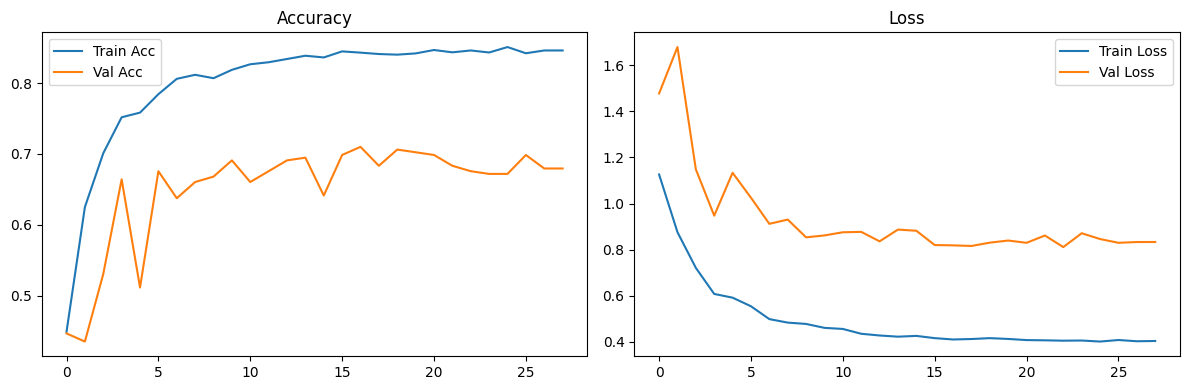

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

plot_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


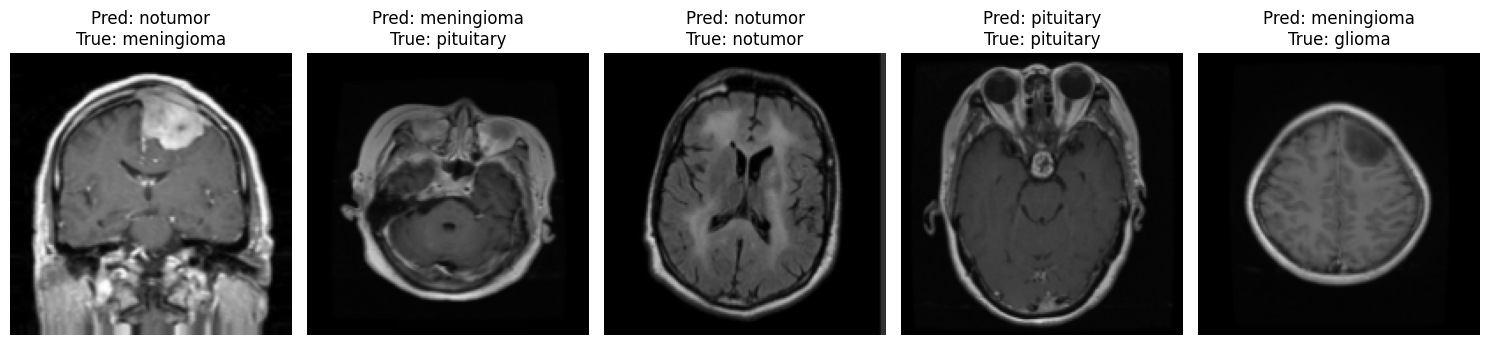

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os

# Load class indices
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Pick some sample images from validation data
val_images, val_labels = next(val_generator)

# Predict
pred_probs = model.predict(val_images)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Display
def show_predictions(images, preds, trues, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(f"Pred: {inv_class_indices[preds[i]]}\nTrue: {inv_class_indices[trues[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(val_images, pred_classes, true_classes, n=5)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step


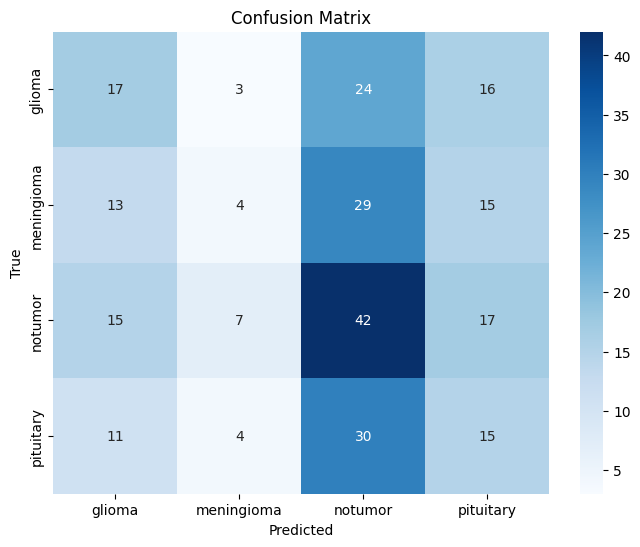

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Reset generator for full iteration
val_generator.reset()

# Predict on entire validation set
pred_probs = model.predict(val_generator, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_generator.classes[:len(pred_classes)]  # ensure equal length

# Class labels
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
